In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs

In [2]:
from numpy import loadtxt
lines = loadtxt("train.txt", comments="\n1", delimiter=",", unpack=False)

In [98]:
lines

array([[ 1.0000e+00,  2.0000e+00,  8.7900e+00],
       [ 1.0000e+00,  5.0000e+00, -7.5200e+00],
       [ 1.0000e+00,  6.0000e+00, -8.5000e+00],
       ...,
       [ 2.4983e+04,  6.4000e+01,  4.2200e+00],
       [ 2.4983e+04,  6.8000e+01,  7.4800e+00],
       [ 2.4983e+04,  6.9000e+01,  5.1500e+00]])

In [97]:
lines_t.shape

(905756, 3)

In [4]:
# Create R
R = np.full((24983, 100), np.nan)

In [5]:
for i in np.arange(0,lines.shape[0]):
        
        user = int(lines[i][0]-1)
        joke = int(lines[i][1]-1)
        score = lines[i][2]
        
        R[user][joke] = score

In [6]:
Train = R
Train

array([[  nan,  8.79,   nan, ...,   nan,   nan,   nan],
       [  nan, -0.29,   nan, ...,  0.34, -4.32,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,  2.67,   nan, ...,   nan,   nan,   nan]])

In [7]:
# Create test set

Test = np.full((24983, 100), np.nan)
lines_t = loadtxt("test.txt", comments="\n1", delimiter=",", unpack=False)
for i in np.arange(0,lines_t.shape[0]):
        
        user = int(lines_t[i][0]-1)
        joke = int(lines_t[i][1]-1)
        score = lines_t[i][2]
        
        Test[user][joke] = score

In [8]:
Test.shape

(24983, 100)

In [9]:
# SVD for dimension reduction
    
def svd_decomposition(train, k):

    # Singular-value decomposition
    U, s, VT = svds(train, k = k)
    
    s = np.diag(s)

    # transform
    T = U@s@VT
    return T

In [10]:
Train_pca = np.nan_to_num(Train)
Test_pca = np.nan_to_num(Test)


In [11]:
# Calculate metrics

def calculate_metrics(U, Test_pca, t_x, t_y):
    
    # mean squared error:
    
    mse = np.mean((U[t_x, t_y] - Test_pca[t_x, t_y])**2)
    
    mae = np.mean(np.abs(U[t_x, t_y] - Test_pca[t_x, t_y]))
    
    return mse, mae

In [13]:
# loop through differenct values of d and caculate mse and mae


def SVD(Train_pca, Test_pca, ds):
    
    t_x = np.where(Test  == Test)[0]
    t_y = np.where(Test  == Test)[1]

    MSE = []
    MAE = []
    
    for d in ds:
        
        U = svd_decomposition(Train_pca, d)
        mse, mae = calculate_metrics(U, Test_pca, t_x, t_y)
        MSE.append(mse)
        MAE.append(mae)
    
    return MSE, MAE

In [14]:
ds = [1,2,5,10,20,50]
mse, mae = SVD(Train_pca, Test_pca, ds)

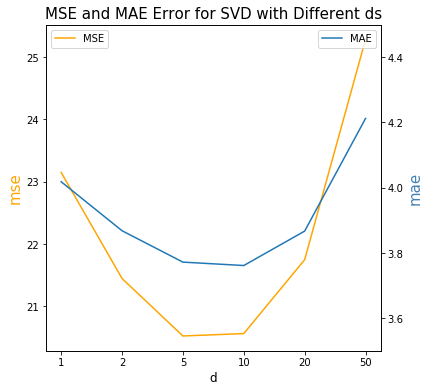

In [16]:
fig, ax1 = plt.subplots(figsize = (6,6))

ax1.plot(mse, label='MSE', color = 'orange')
plt.xticks([0,1,2,3,4,5], ds)
ax1.set_xlabel('d', fontsize = 12)
ax1.set_ylabel('mse', fontsize = 15, color = 'orange')

ax2 = ax1.twinx()
ax2.plot(mae, label = 'MAE')
ax2.set_ylabel('mae', fontsize = 15, color = 'steelblue')
ax2.set_ylim(3.5,4.5)
ax2.legend()
ax1.legend()


plt.title('MSE and MAE Error for SVD with Different ds', fontsize = 15)
plt.savefig('SVD_Error_d.png')

In [19]:
# randomly initialise U and V

U = np.random.randn(Train.shape[0], 50)
V = np.random.randn(50, Train.shape[1])

In [18]:
def update_U(lines, U, V, lamb, batch):
    
    # mini-batch SGD of batch size = batch
    batch_idx = np.random.choice(np.arange(0, U.shape[0]),
                                 batch, replace= False)
     
    for a in batch_idx:
        
        # user id is in batch_idx
        u_idx = np.where(lines[:, 0] == a+1)
        
        # get the corresponding joke id+1 and score
        v_idx = lines[:, 1][u_idx]
        scores = lines[:,2][u_idx]
        
        # get joke id
        v_idx = v_idx.astype(int)
        v_idx = v_idx-1
        
        
        Vs = V[:, v_idx]
        
        # Solve the Linear Equations to set gradient = 0
        u_a = np.linalg.solve((Vs@Vs.T) + lamb*np.eye(U.shape[1]), 
                              Vs@scores - lamb* np.sum(Vs.T))
        U[a,:] = u_a
    
    return U

In [19]:
def update_V(lines, U, V,  lamb):
    
    
    for a in np.arange(0, V.shape[1]):
        
        v_idx = np.where(lines[:, 1] == a+1)
        u_idx = lines[:, 0][v_idx]
        scores = lines[:,2][v_idx]
        
        u_idx = u_idx.astype(int)
        u_idx = u_idx-1
        
        Us = U[u_idx, :].T
        v_a = np.linalg.solve((Us@Us.T) +\
                              lamb*np.eye(U.shape[1]), Us@scores - lamb * np.sum(U))
        V[:,a] = v_a
    
    return V

In [25]:
def calculate_loss(Real, U, V, xs, ys, lamb, Real_t, xs_t, ys_t):

    mse = np.mean(((U@V)[xs,ys]- Real)**2) 
    loss = mse
    mae = np.mean(np.abs((U@V)[xs, ys] - Real))
    
    mse_t = np.mean(((U@V)[xs_t, ys_t]- Real_t)**2)
    mae_t = np.mean(np.abs((U@V)[xs_t, ys_t]- Real_t))
    
    
    return loss, mse, mae, mse_t, mae_t

In [76]:
U = np.random.randn(Train.shape[0], 5)
V = np.random.randn(5, Train.shape[1])

In [ ]:
Loss = []
MSE = []
MAE = []
MSE_T  = []
MAE_T = []

lamb = (1e-3)*2
batch = 1000

# scores for the training and test set
Real = lines[:,2]
Real_t = lines_t[:,2]


# User id and joke id in the training set 
xs = (lines[:,0]-1).astype(int)
ys = (lines[:,1]-1).astype(int)

# User id and joke id in the test set
xs_t = (lines_t[:,0]-1).astype(int)
ys_t = (lines_t[:,1]-1).astype(int)

loss, mse, mae, mse_t, mae_t = calculate_loss(Real, U, V, 
                                              xs, ys, lamb, 
                                              Real_t, xs_t, ys_t)
Loss.append(loss)
MSE.append(mse)
MAE.append(mae)
MSE_T.append(mse_t)
MAE_T.append(mae_t)

for i in np.arange(0,100):
    print(i)
    U = update_U(lines, U, V,  lamb, batch)
    V = update_V(lines, U, V,  lamb)
    
    loss, mse, mae, mse_t, mae_t = calculate_loss(Real, U, V,
                                                  xs, ys, lamb, 
                                                  Real_t, xs_t, ys_t)
    print(loss)
    Loss.append(loss)
    MSE.append(mse)
    MAE.append(mae)
    MSE_T.append(mse_t)
    MAE_T.append(mae_t)
    
    

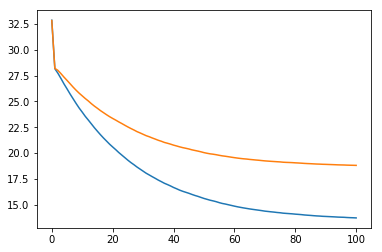

In [79]:
plt.plot(MSE)
plt.plot(MSE_T)

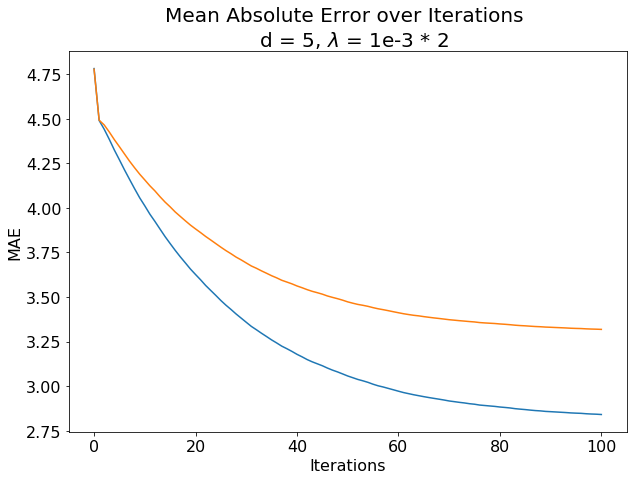

In [94]:
plt.figure(figsize = (10,7))

plt.plot(MAE, label = 'Training')
plt.plot(MAE_T, label = 'Test')
plt.title("Mean Absolute Error over Iterations \n  d = 5, $ \lambda $ = 1e-3 * 2", fontsize = 20)
plt.xlabel('Iterations', fontsize = 16)
plt.ylabel('MAE', fontsize = 16)
x = plt.xticks(fontsize = 16)
y = plt.yticks(fontsize = 16)
plt.savefig('MAE.png')

In [232]:
Losses = []
MSEs= []
MAEs = []
MSE_Ts = []
MAE_Ts = []

In [301]:
Losses.append(Loss[-1])
MSEs.append(MSE[-1])
MAEs.append(MAE[-1])
MSE_Ts.append(MSE_T[-1])
MAE_Ts.append(MAE_T[-1])

In [311]:
MSEs = [MSEs[i]/904699 for i in np.arange(0,6)]

In [313]:
MSE_Ts = [MSE_Ts[i]/905756 for i in np.arange(0,6)]

MAEs = [MAEs[i]/904699 for i in np.arange(0,6)]
MAE_Ts = [MAE_Ts[i]/905756 for i in np.arange(0,6)]

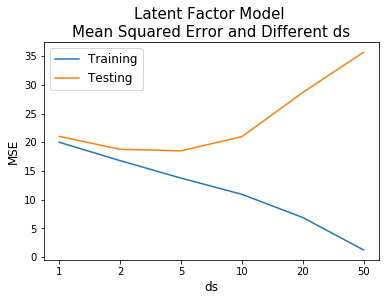

In [320]:


plt.plot(MSEs, label = 'Training')
plt.plot(MSE_Ts, label = 'Testing')
plt.title('''Latent Factor Model 
Mean Squared Error and Different ds''', fontsize = 15)
plt.xlabel('ds', fontsize = 12)
plt.ylabel('MSE', fontsize = 12)
plt.legend(fontsize = 12)
plt.xticks([0,1,2,3,4,5], ds)

plt.savefig('MSE_ds.png')

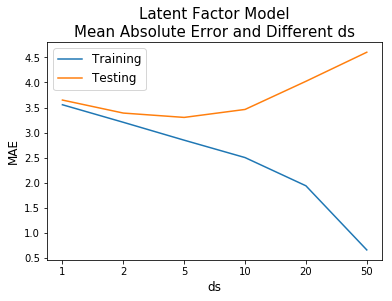

In [321]:
plt.plot(MAEs, label = 'Training')
plt.plot(MAE_Ts, label = 'Testing')
plt.title('''Latent Factor Model
Mean Absolute Error and Different ds''', fontsize = 15)
plt.xlabel('ds', fontsize = 12)
plt.ylabel('MAE', fontsize = 12)
plt.legend(fontsize = 12)
plt.xticks([0,1,2,3,4,5], ds)

plt.savefig('MAE_ds.png')